<a href="https://colab.research.google.com/github/VanChung-Nguyen/Nonlinear-and-Data-Driven-Estimation-3D-Drone/blob/main/EKF3DDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 7.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-43zfvt6e
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-43zfvt6e
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=d66c0a9bacf0fc86a788e5b0e32686479ae9b4d991bf7a7af8fe2ed90b4e0446
  Stored in directory: /tmp/pip-ephem-wheel-cache-8hsl69rr/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import sys
import requests
import importlib
import importlib.util
from pathlib import Path

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # 1) Try local import
    try:
        if directory is not None:
            directory = str(Path(directory).resolve())
            if directory not in sys.path:
                sys.path.insert(0, directory)
        module = importlib.import_module(package_name)
        return getattr(module, function_name) if function_name else module
    except ModuleNotFoundError:
        pass  # fall through to GitHub fetch
    except Exception as e:
        # If module exists but some other error occurred, surface it
        raise

    # 2) Fetch from GitHub (RAW)
    if giturl is None:
        giturl = (
            "https://raw.githubusercontent.com/"
            "VanChung-Nguyen/ME-793-Mathematical-model-simulation-of-3D-Drone/"
            f"main/Utility/{package_name}.py"
        )

    try:
        headers = {"User-Agent": "import_local_or_github/1.0"}
        r = requests.get(giturl, headers=headers, timeout=15)
        r.raise_for_status()
    except requests.RequestException as e:
        raise RuntimeError(f"Failed to fetch module from GitHub URL:\n{giturl}\nError: {e}")

    # Save to CWD as {package_name}.py so Python can import it
    target_path = Path.cwd() / f"{package_name}.py"
    target_path.write_text(r.text, encoding=r.encoding or "utf-8")

    # Make sure Python sees the new file
    importlib.invalidate_caches()

    # 3) Import the freshly written module
    module = importlib.import_module(package_name)
    return getattr(module, function_name) if function_name else module


# Usage
drone = import_local_or_github('drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', function_name='plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')


In [4]:
f = drone.F().f
#3 type of measurement: h_all, h_opticalimu (h_opticalimu : the optical flow with measurement z), h_gpsimu
h = drone.H('h_opticalimu').h

In [5]:
print('states:')
print(f(None, None, return_state_names=True))
print()
print('measurements:')
print(h(None, None, return_measurement_names=True))

states:
['x', 'y', 'z', 'phi', 'theta', 'psi', 'xdot', 'ydot', 'zdot', 'phidot', 'thetadot', 'psidot']

measurements:
['optic_flow_x', 'optic_flow_y', 'phi', 'theta', 'psi', 'phidot', 'thetadot', 'psidot', 'ax', 'ay', 'az']


In [71]:
# 6 types of trajectory: 'maneuvers','circle','lemniscate','squiggle','random','constant_psidot'
t_sim, x_sim, u_sim, y_sim, simulator = drone.simulate_drone(f, h=h, dt=0.05, tsim_length= 20,trajectory_shape='circle')

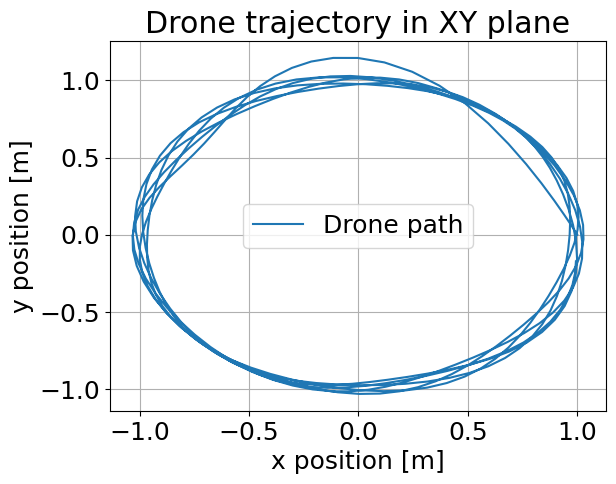

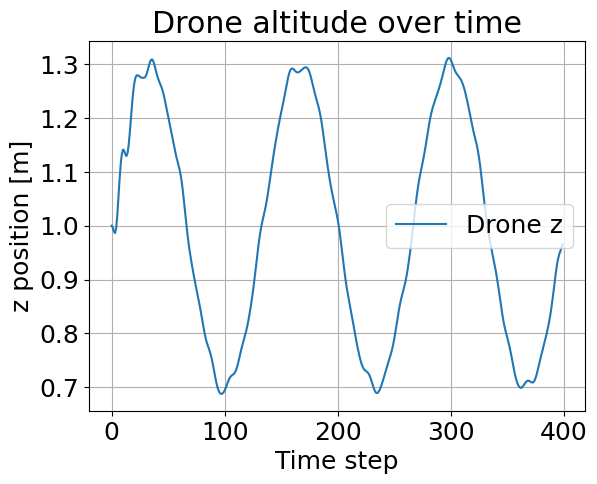

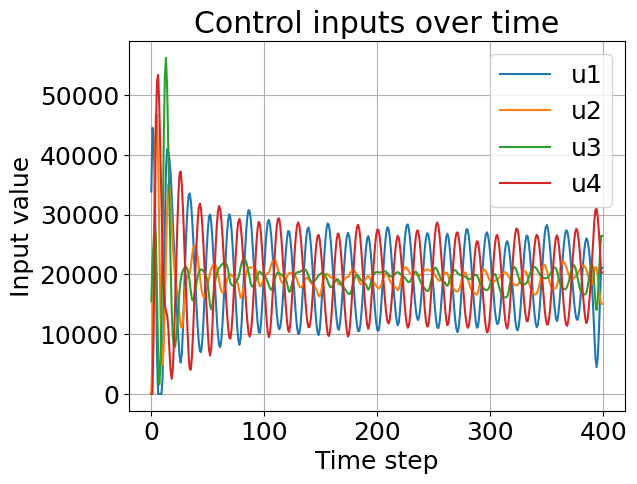

In [72]:
# === 1. Plot XY trajectory ===
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_sim['x'], x_sim['y'], label='Drone path')
ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_title('Drone trajectory in XY plane')
ax.legend()
ax.grid(True)
plt.show()

# === 2. Plot Z (altitude) over time ===
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(x_sim['z'], label='Drone z')
ax1.set_xlabel('Time step')
ax1.set_ylabel('z position [m]')
ax1.set_title('Drone altitude over time')
ax1.legend()
ax1.grid(True)
plt.show()

# === 3. Plot control inputs (u_sim) ===
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# Loop through each control input
for key in u_sim.keys():
    ax2.plot(u_sim[key], label=key)

ax2.set_xlabel('Time step')
ax2.set_ylabel('Input value')
ax2.set_title('Control inputs over time')
ax2.legend()
ax2.grid(True)
plt.show()

In [73]:
measurement_noise_stds = {'optic_flow_x': 0.25,
                          'optic_flow_y': 0.25,
                          'phi': 0.1,
                          'theta': 0.1,
                          'psi': 0.1,
                          'phidot': 0.1,
                          'thetadot': 0.1,
                          'psidot': 0.1,
                          'ax': 0.2,
                          'ay': 0.2,
                          'az': 0.2
                         }

In [74]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow_x'>

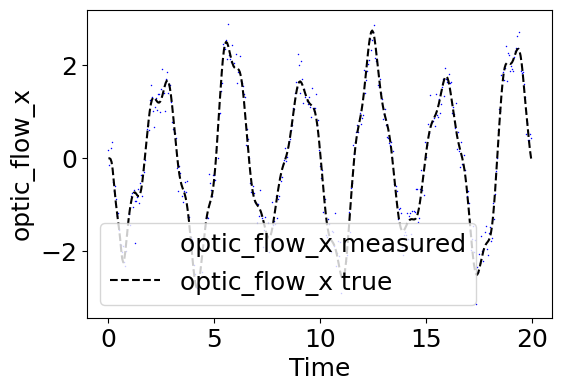

In [75]:
plot_tme(t_sim, y_sim['optic_flow_x'], y_noisy['optic_flow_x'], label_var='optic_flow_x')

<Axes: xlabel='Time', ylabel='ax'>

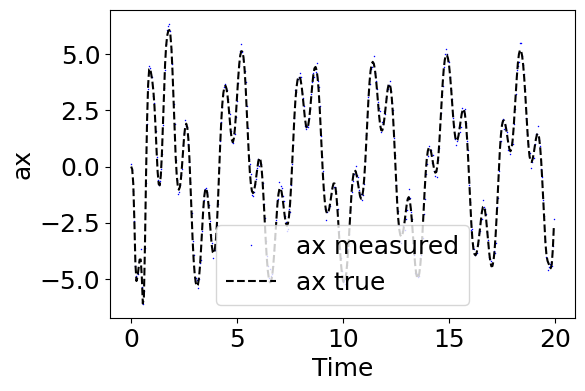

In [76]:
plot_tme(t_sim, y_sim['ax'], y_noisy['ax'], label_var='ax')

In [77]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

In [78]:
x0 = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
u0 = np.array([17854.2, 17854.2, 17854.2, 17854.2])

P0 = np.eye(12)*10
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-4]*len(x0))
dt = np.mean(np.diff(t_sim))

In [79]:
EKF = extended_kalman_filter.EKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous',
                                 discretization_timestep=dt,
                                 circular_measurements=(0,0,0,0,0,0,0,0,0,0,0,0))

In [80]:
EKF.estimate(y_noisy_df, u_sim_df)

In [81]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [82]:
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=f(None,None,return_state_names=True))

In [83]:
P_diags = np.vstack([EKF.history['P_diags'][i] for i in range(len(EKF.history['P_diags']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

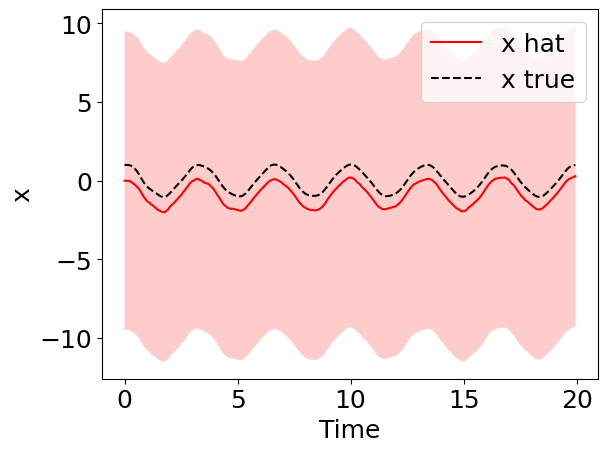

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)